Reference:

[1] https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895

[2] https://towardsdatascience.com/a-beginners-tutorial-on-building-an-ai-image-classifier-using-pytorch-6f85cb69cba7

#### Import Required Libraries

In [1]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import time
import torch
import torchvision
import torchsummary
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

#import albumentations as A
#from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm
import os

#### Magic Function

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%reload_ext autoreload
%autoreload 2

#### Fix matplotlib issue

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### Input Data Files Structure

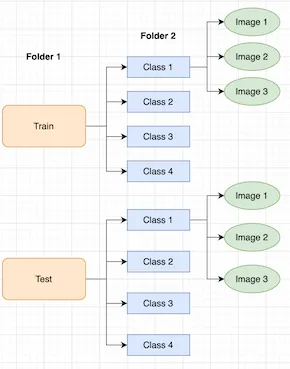

####################################################
#       Create Train, Valid and Test sets
####################################################

In [4]:
train_data_path = 'data\\Train' 
test_data_path = 'data\\Test'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '\*'):
    classes.append(data_path.split('\\')[-1]) 
    train_image_paths.append(glob.glob(data_path + '\*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 

#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '\*'):
    test_image_paths.append(glob.glob(data_path + '\*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

train_image_path example:  data\Train\03.Dead_Sea\3e81a5ee90da12a0.jpg
class example:  02.Ljubljana_Castle
Train size: 160
Valid size: 40
Test size: 50


#######################################################
#      Create dictionary for class indexes
#######################################################

In [5]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [6]:
idx_to_class 

{0: '02.Ljubljana_Castle', 1: '03.Dead_Sea'}

In [7]:
class_to_idx

{'02.Ljubljana_Castle': 0, '03.Dead_Sea': 1}

In [8]:
train_transforms = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Resize((255,255)),
     transforms.CenterCrop(32),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = train_transforms # seperate transform can be defined for test

#######################################################
#               Define Dataset Class
#######################################################

In [9]:
class LandmarkDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('\\')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label
    


#######################################################
#                  Create Dataset
#######################################################

In [10]:
train_dataset = LandmarkDataset(train_image_paths, train_transforms)
valid_dataset = LandmarkDataset(valid_image_paths, test_transforms) #test transforms are applied
test_dataset = LandmarkDataset(test_image_paths, test_transforms)

In [11]:
print('The shape of tensor for 50th image in train dataset: ', train_dataset[0][0].shape)
print('The label for 50th image in train dataset: ', train_dataset[0][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 32, 32])
The label for 50th image in train dataset:  1


#######################################################
#                  Define Dataloaders
#######################################################

In [12]:
train_loader = DataLoader(
    train_dataset, batch_size=4, shuffle=True)

valid_loader = DataLoader(
    valid_dataset, batch_size=4, shuffle=True)


test_loader = DataLoader(
    test_dataset, batch_size=4, shuffle=False)

In [13]:
dataloaders = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])


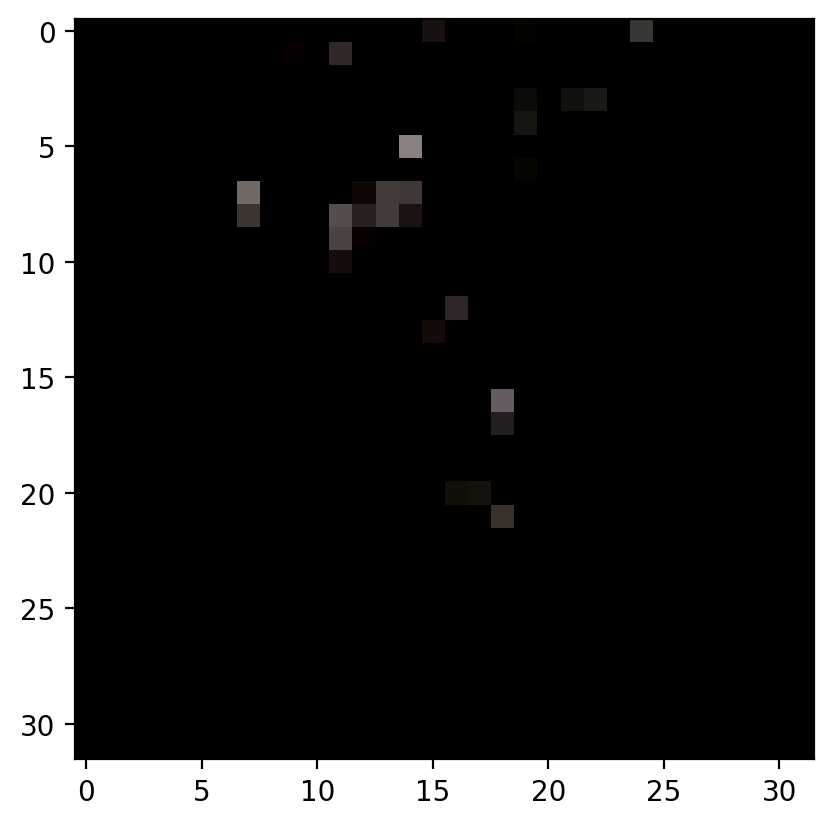

(32, 32, 3)


In [14]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap = 'gray')
    plt.show()
    print(np.transpose(npimg, (1, 2, 0)).shape)

for batch in train_loader:
    print(batch[0][0].shape)
    imshow(batch[0][0])
    break

#######################################################
#                  Define the Classification Model
#######################################################

In [15]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        self.layer1 = self.ConvModule(in_features=3, out_features=64)      #16,16
        self.layer2 = self.ConvModule(in_features=64, out_features=128)    #8,8
        self.layer3 = self.ConvModule(in_features=128, out_features=256)   #4,4
        self.layer4 = self.ConvModule(in_features=256, out_features=512)   #2,2

        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(2*2*512, 1024),
                                        nn.ReLU(),
                                        nn.Linear(1024, 512),
                                        nn.ReLU(),
                                        nn.Linear(512,10),
                                        nn.Softmax())
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.classifier(x)
        return x
    
    def ConvModule(self, in_features, out_features):
        return nn.Sequential(nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, padding=1),
                            nn.BatchNorm2d(out_features),
                            nn.ReLU(),
                            nn.MaxPool2d(2,2)
                            )
        
model = CustomCNN()#.to(device)

In [16]:
torchsummary.summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
        MaxPool2d-12            [-1, 256, 4, 4]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-14            [-1, 51

C:\Users\basharm\AppData\Local\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


#######################################################
#                  Define Training Functionality
#######################################################

In [17]:
learning_rate = 0.001
num_epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [18]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    test_acc_history = []
    test_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # training mode
            else:
                model.eval()   # evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs#.to(device)
                labels = labels#.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}, Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test':
                test_acc_history.append(epoch_acc.cpu().numpy())
                test_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc.cpu().numpy())
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    history_dict = {'train_loss':train_loss_history, 'train_accuracy':train_acc_history,
                    'test_loss':test_loss_history, 'test_accuracy':test_acc_history}
    return model, history_dict

model, hist= train_model(model, dataloaders, criterion, optimizer, num_epochs)

Epoch 1/3
train Loss: 2.2601, Acc: 0.4250
test Loss: 2.1953, Acc: 0.5800

Epoch 2/3
train Loss: 2.0003, Acc: 0.5875
test Loss: 1.8904, Acc: 0.6400

Epoch 3/3
train Loss: 1.8604, Acc: 0.6438
test Loss: 1.8454, Acc: 0.6200

Training complete in 0m 5s
Best test Acc: 0.000000


#### Visualise the performance

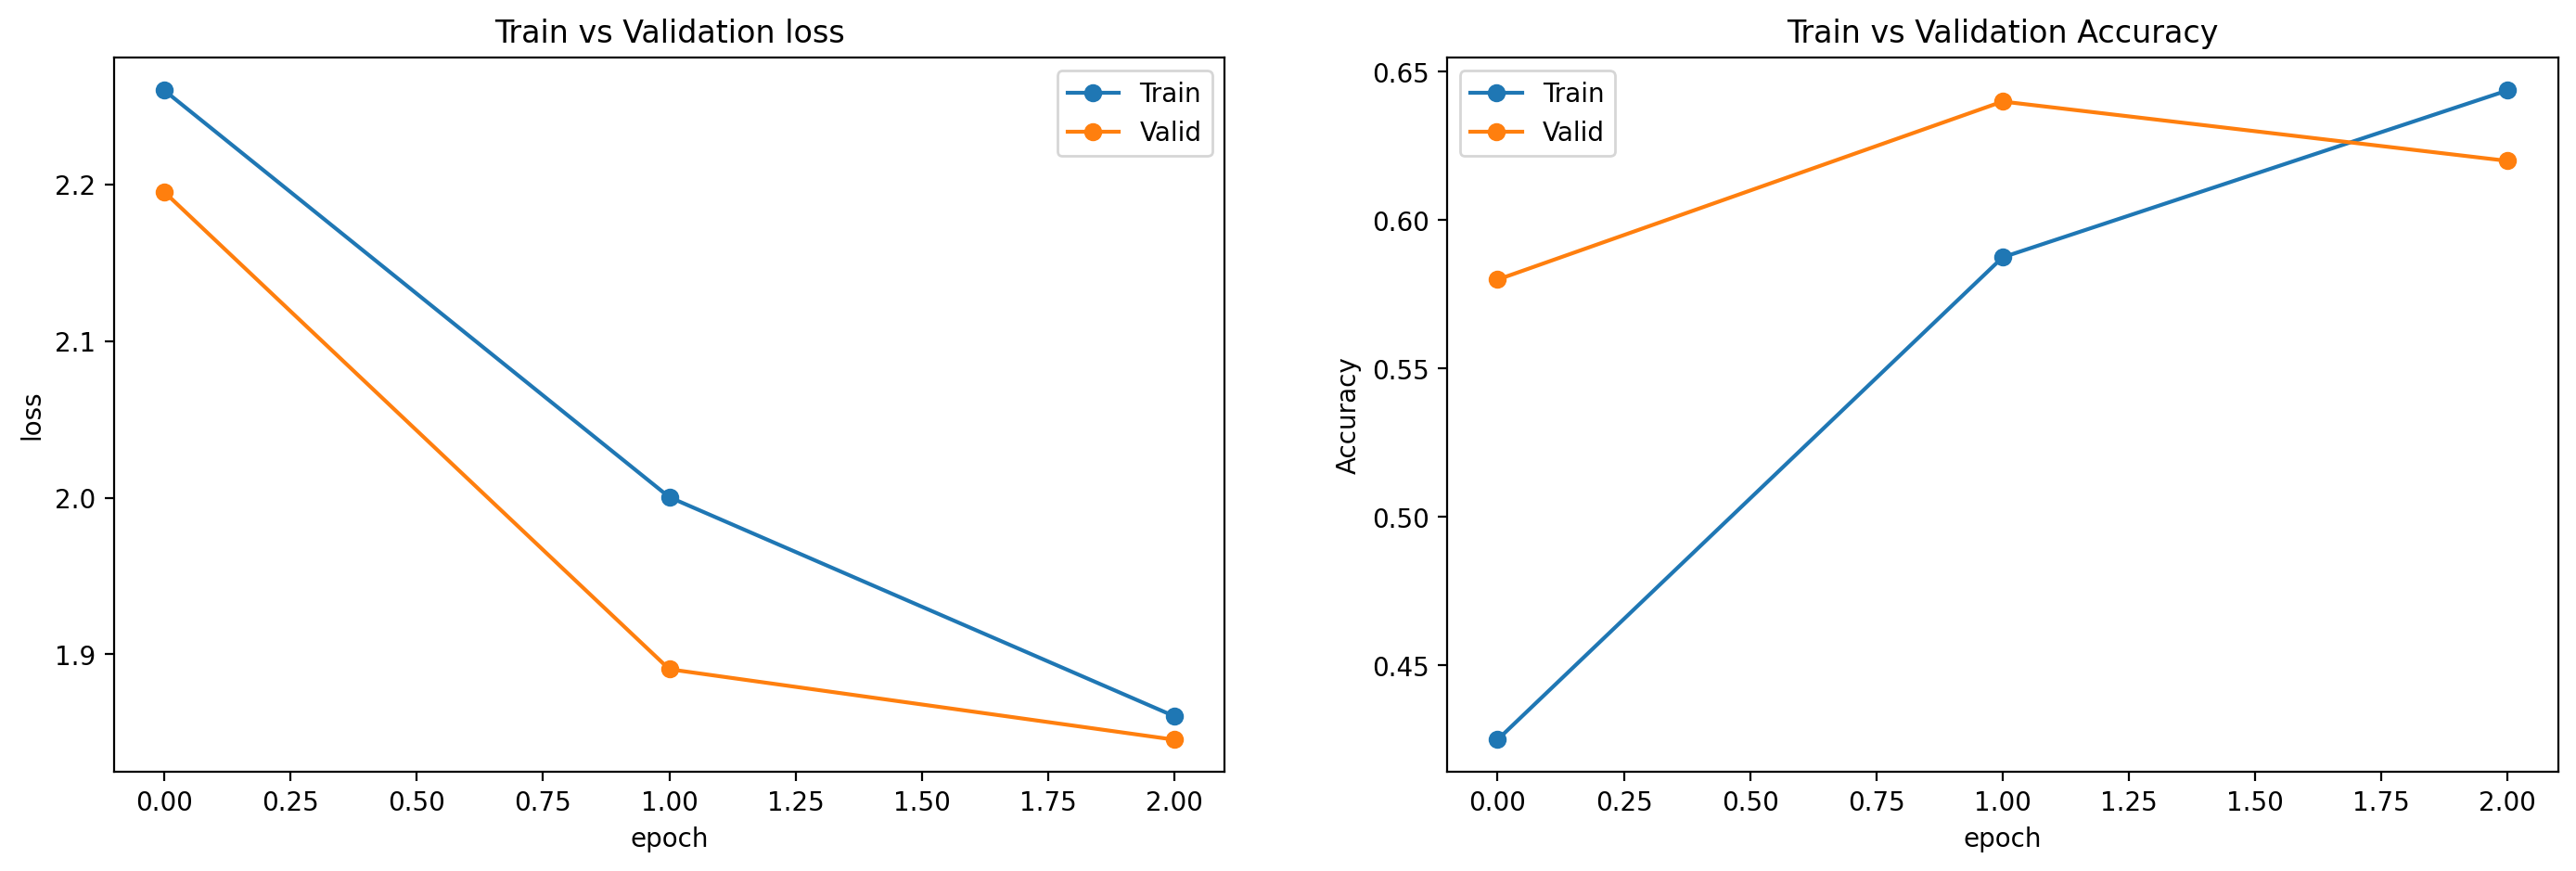

In [19]:
plt.figure(figsize=(17,5))
plt.subplot(121)
plt.plot(hist['train_loss'],'-o')
plt.plot(hist['test_loss'],'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Validation loss')

plt.subplot(122)
plt.plot(hist['train_accuracy'],'-o')
plt.plot(hist['test_accuracy'],'-o')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Validation Accuracy')

 
plt.show()

### Saving & Loading Model for Inference


What is a state_dict?

In PyTorch, the learnable parameters (i.e. weights and biases) of an torch.nn.Module model are contained in the model’s parameters (accessed with model.parameters()). A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor. Note that only layers with learnable parameters (convolutional layers, linear layers, etc.) and registered buffers (batchnorm’s running_mean) have entries in the model’s state_dict. Optimizer objects (torch.optim) also have a state_dict, which contains information about the optimizer’s state, as well as the hyperparameters used.

Because state_dict objects are Python dictionaries, they can be easily saved, updated, altered, and restored, adding a great deal of modularity to PyTorch models and optimizers.

When it comes to saving and loading models, there are three core functions to be familiar with:

    torch.save: Saves a serialized object to disk. This function uses Python’s pickle utility for serialization. Models, tensors, and dictionaries of all kinds of objects can be saved using this function.

    torch.load: Uses pickle’s unpickling facilities to deserialize pickled object files to memory. This function also facilitates the device to load the data into (see Saving & Loading Model Across Devices).

    torch.nn.Module.load_state_dict: Loads a model’s parameter dictionary using a deserialized state_dict. For more information on state_dict, see What is a state_dict?.


In [31]:
PATH=r'Model_Classifier\classifier.state_dict'
torch.save(model.state_dict(), PATH)

In [33]:
model = CustomCNN()
model.load_state_dict(torch.load(PATH))
model.eval();

### Make Inference

In [50]:
def predict_image(test_dataset, index):
    image_tensor, label = test_dataset.__getitem__(index)
    indata = image_tensor.unsqueeze_(0)
    output = model(indata)
    index = output.data.cpu().numpy().argmax()
    return index

predict_image(test_dataset, index=2)

1